In [1]:
!wget https://mmseqs.com/latest/mmseqs-linux-avx2.tar.gz
!tar xvfz mmseqs-linux-avx2.tar.gz
!export PATH=$(pwd)/mmseqs/bin/:$PATH

--2025-12-11 19:21:09--  https://mmseqs.com/latest/mmseqs-linux-avx2.tar.gz
Resolving mmseqs.com (mmseqs.com)... 158.247.200.62
Connecting to mmseqs.com (mmseqs.com)|158.247.200.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19142567 (18M) [application/octet-stream]
Saving to: ‘mmseqs-linux-avx2.tar.gz’

mmseqs-linux-avx2.t 100%[===================>]  18.25M  5.62MB/s    in 3.2s    

2025-12-11 19:21:13 (5.62 MB/s) - ‘mmseqs-linux-avx2.tar.gz’ saved [19142567/19142567]

mmseqs/
mmseqs/userguide.pdf
mmseqs/examples/
mmseqs/examples/DB.fasta
mmseqs/examples/QUERY.fasta
mmseqs/LICENSE.md
mmseqs/README.md
mmseqs/matrices/
mmseqs/matrices/PAM120.out
mmseqs/matrices/PAM190.out
mmseqs/matrices/PAM130.out
mmseqs/matrices/blosum62.out
mmseqs/matrices/blosum80.out
mmseqs/matrices/blosum95.out
mmseqs/matrices/PAM20.out
mmseqs/matrices/blosum75.out
mmseqs/matrices/blosum100.out
mmseqs/matrices/PAM40.out
mmseqs/matrices/PAM100.out
mmseqs/matrices/VTML200.out
mmseqs/mat

In [2]:
!./mmseqs/bin/mmseqs easy-cluster /kaggle/input/cafa-6-protein-function-prediction/Train/train_sequences.fasta cluster_res tmp \
    --min-seq-id 0.3 \
    -c 0.8 \
    --cov-mode 0 \
    --threads 4 \
    --split-memory-limit 6G

Create directory tmp
easy-cluster /kaggle/input/cafa-6-protein-function-prediction/Train/train_sequences.fasta cluster_res tmp --min-seq-id 0.3 -c 0.8 --cov-mode 0 --threads 4 --split-memory-limit 6G 

MMseqs Version:                     	bd01c2229f027d8d8e61947f44d11ef1a7669212
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	6G
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Compositional bias sc

In [3]:
!find /kaggle/input -type f -name "*fasta"

/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset.fasta
/kaggle/input/cafa-6-protein-function-prediction/Train/train_sequences.fasta


In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.model_selection import GroupKFold

# ========================================================
#  CẤU HÌNH 
# ========================================================
LABEL_DIR = "/kaggle/input/go-cafa6"
EMBED_DIR = "/kaggle/input/cafa6-embeds"
TRAIN_IDS_FILE = os.path.join(EMBED_DIR, "train_ids.txt") 
CLUSTER_FILE = "/kaggle/working/cluster_res_cluster.tsv" 

N_FOLDS = 5 
SEED = 42

# =========================================================
# 1. HÀM LOAD CLUSTER
# =========================================================
def load_cluster_mapping(cluster_path):
    if not os.path.exists(cluster_path):
        print("Không tìm thấy file Cluster! Sẽ dùng Random Split.")
        return None
    print(f" Loading Cluster info from {cluster_path}...")
    df_clusters = pd.read_csv(cluster_path, sep='\t', names=['Rep', 'Member'])
    mapping = df_clusters.set_index('Member')['Rep'].to_dict()
    return mapping

# =========================================================
# 2. HÀM TẠO MASTER SPLIT 
# =========================================================
def create_master_split(cluster_mapping):
    print("\n========================================================")
    print(" CREATING MASTER SPLIT (GLOBAL CONSISTENCY)")
    print("========================================================")
    
    # A. Load Master List từ Embeddings
    if TRAIN_IDS_FILE.endswith('.npy'):
        master_list = np.load(TRAIN_IDS_FILE)
        master_list = sorted(master_list) # SORT LÀ BẮT BUỘC
    else:
        with open(TRAIN_IDS_FILE, 'r') as f:
            master_list = sorted([x.strip() for x in f if x.strip()])
            
    print(f"   - Master Protein Count: {len(master_list):,}")
    
    # Tạo DataFrame để Split
    split_df = pd.DataFrame({'id': master_list})
    
    if cluster_mapping is not None:
        split_df['cluster'] = split_df['id'].map(cluster_mapping).fillna(split_df['id'])
    else:
        split_df['cluster'] = split_df['id']
        
    # C. Split GroupKFold
    gkf = GroupKFold(n_splits=N_FOLDS)
    
    # Chỉ lấy Fold 0 làm Val, còn lại là Train
    for train_idx, val_idx in gkf.split(split_df['id'], groups=split_df['cluster']):
        global_train_ids = set(split_df['id'].iloc[train_idx].values)
        global_val_ids = set(split_df['id'].iloc[val_idx].values)
        break 
        
    print(f"   Master Split Created.")
    print(f"   - Global Train: {len(global_train_ids):,}")
    print(f"   - Global Val:   {len(global_val_ids):,}")
    
    return global_train_ids, global_val_ids

# =========================================================
# 3. HFILTER & SAVE 
# =========================================================
def filter_and_save(coverage_name, global_train_set, global_val_set):
    print(f"\n🔹 Processing subset: {coverage_name}...")
    
    # Paths
    TRAIN_LABEL_FILE = os.path.join(LABEL_DIR, f"train_data_{coverage_name}_remove.tsv")
    VOCAB_FILE = os.path.join(LABEL_DIR, f"vocab_{coverage_name}_remove.csv")
    OUTPUT_PKL = f"train_targets_{coverage_name}.pkl"
    TRAIN_OUT = f"train_ids_{coverage_name}_split.npy"
    VAL_OUT = f"val_ids_{coverage_name}_split.npy"
    
    # Load Vocab
    vocab = pd.read_csv(VOCAB_FILE)
    term_to_idx = {t: i for i, t in enumerate(vocab['term'])}
    
    # Load Labels
    df = pd.read_csv(TRAIN_LABEL_FILE, sep="\t", names=["protein", "term", "aspect"])
    
    # Chỉ lấy những dòng hợp lệ
    df = df[df['term'].isin(term_to_idx)]
    df['label_idx'] = df['term'].map(term_to_idx)
    
    # Tạo Dictionary Targets
    labels_dict = df.groupby('protein')['label_idx'].apply(list).to_dict()
    
    with open(OUTPUT_PKL, 'wb') as f:
        pickle.dump(labels_dict, f)
        
    # --- FILTER TỪ GLOBAL SET ---
    valid_prots = set(labels_dict.keys())
    
    final_train_ids = np.array(sorted(list(global_train_set.intersection(valid_prots))))
    final_val_ids = np.array(sorted(list(global_val_set.intersection(valid_prots))))
    
    # Save
    np.save(TRAIN_OUT, final_train_ids)
    np.save(VAL_OUT, final_val_ids)
    
    print(f"   - Subset Train: {len(final_train_ids):,}")
    print(f"   - Subset Val:   {len(final_val_ids):,}")
    print(f"   Saved: {TRAIN_OUT} & {VAL_OUT}")

if __name__ == "__main__":
    cluster_map = load_cluster_mapping(CLUSTER_FILE)
    
    g_train, g_val = create_master_split(cluster_map)
    
    for name in ['C95', 'C99']:
        filter_and_save(name, g_train, g_val)
        
    print("\nDONE! Data consistency guaranteed.")

📦 Loading Cluster info from /kaggle/working/cluster_res_cluster.tsv...

🚀 CREATING MASTER SPLIT (GLOBAL CONSISTENCY)
   - Master Protein Count: 82,404
   Master Split Created.
   - Global Train: 65,923
   - Global Val:   16,481

🔹 Processing subset: C95...
   - Subset Train: 65,921
   - Subset Val:   16,481
   ✅ Saved: train_ids_C95_split.npy & val_ids_C95_split.npy

🔹 Processing subset: C99...
   - Subset Train: 65,923
   - Subset Val:   16,481
   ✅ Saved: train_ids_C99_split.npy & val_ids_C99_split.npy

DONE! Data consistency guaranteed.


📊 PHÂN TÍCH TAXONOMY (FINAL REPORT VERSION)

Tổng Taxa: 1381
Vùng học tốt (Freq >= 10): 140
Vùng chết (Freq < 10): 1241

--- TẠO MAPPING TAXONOMY CHO TRAIN ---
K_FINAL (freq ≥ 10) = 140
UNK_IDX = 140

--- KẾT QUẢ LƯU FILE ---
   - Số lớp Taxonomy (kể cả UNK): 141
   - Số Protein rơi vào UNK     : 2,719
   - Coverage taxonomy riêng   : 96.70%
   - File mapping đã lưu       : /kaggle/working/taxon_mapping_K140.pkl

--- K THEO NGƯỠNG FREQ >= 10 ---
Tổng số taxonomy           : 1381
K (freq ≥ 10)      : 140
Dead-zone (freq < 10) : 1241 (89.86%)


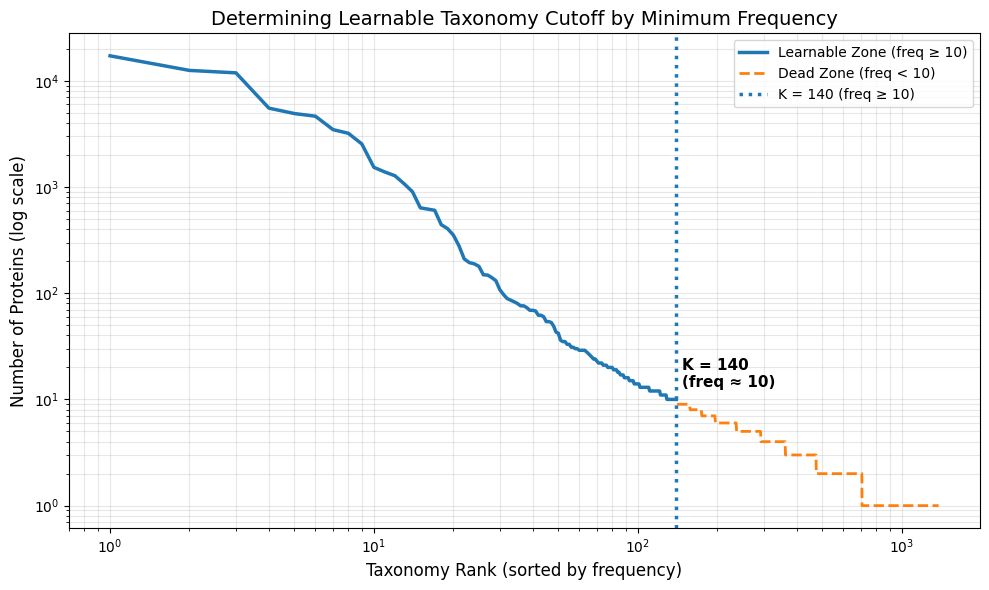

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import pickle

# ================================
# CONFIG
# ================================
CONFIG = {
    "TAXON_FILE": "/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv",
    "MIN_SAMPLES_REQUIRED": 10,
    "OUTPUT_PKL": "/kaggle/working/taxon_mapping_K140.pkl"
}

def analyze_for_report_final():
    print(" PHÂN TÍCH TAXONOMY (FINAL REPORT VERSION)\n")
    
    # 1. LOAD DATA
    try:
        df = pd.read_csv(CONFIG["TAXON_FILE"], sep="\t", header=None, names=["Protein", "Taxon"], dtype=str)
    except:
        print("Warning: Không tìm thấy file, tạo dữ liệu giả lập để demo...")
        np.random.seed(42)
        counts = np.random.zipf(1.5, 82000)
        df = pd.DataFrame({'Taxon': counts.astype(str)})

    tax_counts = df["Taxon"].value_counts()
    total_proteins = len(df)
    total_taxa = len(tax_counts)
    
    # 2. CUMULATIVE COVERAGE
    sorted_counts = tax_counts.sort_values(ascending=False)
    cumulative_sum = sorted_counts.cumsum()
    cumulative_percent = cumulative_sum / total_proteins * 100
    
    # Tìm K95, K99
    K95 = np.searchsorted(cumulative_percent, 95) + 1
    K99 = np.searchsorted(cumulative_percent, 99) + 1
    
    min_freq = CONFIG["MIN_SAMPLES_REQUIRED"]
    dead_zone_count = (tax_counts < min_freq).sum()
    valid_learning_zone = total_taxa - dead_zone_count
    
    print(f"Tổng Taxa: {total_taxa}")
    print(f"Vùng học tốt (Freq >= {min_freq}): {valid_learning_zone}")
    print(f"Vùng chết (Freq < {min_freq}): {dead_zone_count}")

    # =================================================================
    # 2. TẠO VÀ LƯU FILE MAPPING 
    # =================================================================
    
    min_freq = CONFIG["MIN_SAMPLES_REQUIRED"]
    
    # Lấy top taxon theo ngưỡng freq ≥ 10
    top_taxa_series = tax_counts[tax_counts >= min_freq]
    K_FINAL = len(top_taxa_series)   # = 140 (theo kết quả của bạn)
    
    # Gán UNK index là vị trí cuối
    UNK_IDX = K_FINAL
    
    print("\n--- TẠO MAPPING TAXONOMY CHO TRAIN ---")
    print(f"K_FINAL (freq ≥ {min_freq}) = {K_FINAL}")
    print(f"UNK_IDX = {UNK_IDX}")
    
    # Map: Taxon ID -> index
    taxon_to_idx = {tid: i for i, tid in enumerate(top_taxa_series.index)}
    
    # Map: Protein ID -> Taxon index (hoặc UNK)
    prot_to_taxon_idx = {
        pid: taxon_to_idx.get(tid, UNK_IDX)
        for pid, tid in zip(df["Protein"], df["Taxon"])
    }
    
    # Gói dữ liệu để lưu
    data_to_save = {
        "taxon_to_idx": taxon_to_idx,
        "prot_to_taxon_idx": prot_to_taxon_idx,
        "num_taxa_classes": K_FINAL + 1,   # +1 cho UNK
        "min_freq_cutoff": min_freq
    }
    
    # LƯU FILE
    with open(CONFIG["OUTPUT_PKL"], "wb") as f:
        pickle.dump(data_to_save, f)
    
    # THỐNG KÊ COVERAGE
    unk_count = list(prot_to_taxon_idx.values()).count(UNK_IDX)
    coverage = (total_proteins - unk_count) / total_proteins * 100
    
    print("\n--- KẾT QUẢ LƯU FILE ---")
    print(f"   - Số lớp Taxonomy (kể cả UNK): {data_to_save['num_taxa_classes']:,}")
    print(f"   - Số Protein rơi vào UNK     : {unk_count:,}")
    print(f"   - Coverage taxonomy riêng   : {coverage:.2f}%")
    print(f"   - File mapping đã lưu       : {CONFIG['OUTPUT_PKL']}")
    
    # =========================
    # BIỂU ĐỒ DUY NHẤT: XÁC ĐỊNH K THEO NGƯỠNG FREQ >= 10
    # =========================
    
    min_freq = CONFIG["MIN_SAMPLES_REQUIRED"]  # = 10
    
    sorted_counts = tax_counts.sort_values(ascending=False)
    freqs = sorted_counts.values
    ranks = np.arange(1, len(freqs) + 1)
    
    # ✅ K chính là số taxonomy có freq >= 10
    K_freq = (freqs >= min_freq).sum()
    dead_zone_count = len(freqs) - K_freq
    
    print("\n--- K THEO NGƯỠNG FREQ >= 10 ---")
    print(f"Tổng số taxonomy           : {len(freqs)}")
    print(f"K (freq ≥ {min_freq})      : {K_freq}")
    print(f"Dead-zone (freq < {min_freq}) : {dead_zone_count} ({dead_zone_count/len(freqs)*100:.2f}%)")
    
    plt.figure(figsize=(10, 6))
    
    # Vùng học được (freq ≥ 10)
    plt.loglog(
        ranks[:K_freq],
        freqs[:K_freq],
        linewidth=2.5,
        label=f"Learnable Zone (freq ≥ {min_freq})"
    )
    
    # Vùng dead-zone (freq < 10)
    plt.loglog(
        ranks[K_freq:],
        freqs[K_freq:],
        linewidth=2,
        linestyle="--",
        label=f"Dead Zone (freq < {min_freq})"
    )
    
    # ĐƯỜNG DỌC CẮT K THEO NGƯỠNG 10 
    plt.axvline(
        x=K_freq,
        linestyle=":",
        linewidth=2.5,
        label=f"K = {K_freq} (freq ≥ {min_freq})"
    )

    plt.text(
        K_freq * 1.05,
        freqs[K_freq-1] * 1.3,
        f"K = {K_freq}\n(freq ≈ {int(freqs[K_freq-1])})",
        fontsize=11,
        fontweight="bold"
    )
    
    plt.title("Determining Learnable Taxonomy Cutoff by Minimum Frequency", fontsize=14)
    plt.xlabel("Taxonomy Rank (sorted by frequency)", fontsize=12)
    plt.ylabel("Number of Proteins (log scale)", fontsize=12)
    
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    analyze_for_report_final()